In [13]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from matplotlib import gridspec

%matplotlib inline

# Define linear program as a function of $P(Y)$, $\lambda$, and $\epsilon$

In [14]:
# Cardinality of X and Y
K = 6
# Shape of the joint distribution, \psi
joint_shape = (K,K,K,K)
def get_lp(pya,
           pyb,
           lamb,
           eps,
           err_const=True,
           mon_const=True,
           sym_const=True,
           pos_effect_of_treatment=True,
           pos_effect_of_truth=True,
           parameter="ate",
           pa=None):
    
    """
        Calculate bounds for various parameters from the potential
        outcome distribution P(X(a),X(b),Y(a),Y(b)) (see Sec. 3 of 
        the main paper). 
        
        Arguments:
        
        pya - (K,) numpy array: 
            P(Y(a))
            
        pyb - (K,) numpy array: 
            P(Y(b))
            
        lamb - float: 
            Slack on (A2).
            
        eps - float:
            Upper bound on the total proportion of errors. Only used 
            if err_const == True.
            
        err_const - bool:
            Include total error constraint (A0).
            
        mon_const - bool:
            Include monotonicity constraint (A2).
            
        sym_const - bool:
            Include symmetry constraint (A3).
            
        pos_effect_of_treatment - bool:
            Include positive effect of treatment on truth constraint (A5).
            
        pos_effect_of_truth - bool:
            Include positive effect of truth on proxy constraint (A6).
            
        parameter - string:
            Possible values are {"ex","exa","exb","ate"}.
            
        pa - (2,) numpy array:
            P(A)
        
    """
    
    assert parameter in {"ate","ex","exa","exb"}
    assert parameter == "ate" or (pa is not None)
    
    # Create objective function weights
    c = np.zeros(joint_shape)
    for xa in range(K):
        for xb in range(K):
            for ya in range(K):
                for yb in range(K):
                    # E[X]
                    if parameter == "ex":
                        c[xa,xb,ya,yb] = xa*pa[0] + xb*pa[1]
                    # E[X(a)]
                    elif parameter == "exa":
                        c[xa,xb,ya,yb] = xa
                    # E[X(b)]
                    elif parameter == "exb":
                        c[xa,xb,ya,yb] = xb
                    # E[X(a) - X(b)]
                    elif parameter == "ate":
                        c[xa,xb,ya,yb] = xa - xb
    c = c.flatten()
    
    # Equality constraints
    A_eq = []
    b_eq = []
    
    # Inequality (upper bound) constraints
    A_ub = []
    b_ub = []
    
    # observed data constraint
    # \sum_{x,x',y'} \phi_{xx'yy'} = P(Y(a)=y)
    for ya in range(K):
        a = np.zeros(joint_shape)
        a[:,:,ya,:] = 1
        A_eq.append(a.flatten())
        b_eq.append(pya[ya])
        
    for yb in range(K-1):
        a = np.zeros(joint_shape)
        a[:,:,:,yb] = 1
        A_eq.append(a.flatten())
        b_eq.append(pyb[yb])
        
        
    # Exclusion restriction
    a = np.zeros(joint_shape)
    for x in range(K):
        for ya in range(K):
            for yb in range(K):
                if ya != yb: 
                    a[x,x,ya,yb] = 1
    A_eq.append(a.flatten())
    b_eq.append(0)
    
    # Positive effect of treatment on truth
    if pos_effect_of_truth:
        a = np.zeros(joint_shape)
        for xa in range(K):
            for xb in range(K):
                for ya in range(K):
                    for yb in range(K):
                        if xa >= xb and ya < yb:
                            a[xa,xb,ya,yb] = 1
                        elif xa <= xb and ya > yb:
                            a[xa,xb,ya,yb] = 1
        A_eq.append(a.flatten())
        b_eq.append(0)
        
    # Positive effect of truth on proxy
    if pos_effect_of_treatment:
        a = np.zeros(joint_shape)
        for xa in range(K):
            for xb in range(K):
                if xa > xb:
                    a[xa,xb,:,:] = 1
        A_eq.append(a.flatten())
        b_eq.append(0)
    
    
    # bound on proportion of errors
    # \sum_{x,y: |x-y| > 2} \phi_{xy} <= \epsilon
    if err_const:
        a = np.zeros(joint_shape)
        for xa in range(K):
            for ya in range(K):
                if np.abs(xa-ya) > 2:
                    a[xa,:,ya,:] = 1
        A_ub.append(a.flatten())
        b_ub.append(eps)
        
        a = np.zeros(joint_shape)
        for xb in range(K):
            for yb in range(K):
                if np.abs(xb-yb) > 2:
                    a[:,xb,:,yb] = 1
        A_ub.append(a.flatten())
        b_ub.append(eps)
    
    # monotonicity constraint
    # \phi_{xy} - \phi_{xy'} <= 0 for all |x - y| > |x - y'|
    if mon_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) < np.abs(x-yp):
                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = -1
                        a[x,:,yp,:] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(0)
                        
                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = -1
                        a[:,x,:,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(0)
                    
    # symmetry constraint
    # |\phi_{xy} - \phi_{xy'}| <= lamb for all |x - y| = |x - y'|
    if sym_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) == np.abs(x-yp) and y != yp:
                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = 1
                        a[x,:,yp,:] = -1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)

                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = -1
                        a[x,:,yp,:] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)
                        
                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = 1
                        a[:,x,:,yp] = -1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)

                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = -1
                        a[:,x,:,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)
                    
    # non-negativity
    bounds = []
    for x in it.product(range(K),repeat=4):
        bounds.append((0,1))

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)
    
    if len(A_ub) == 0:
        A_ub = None
        b_ub = None
    else:
        A_ub = np.array(A_ub)
        b_ub = np.array(b_ub)
    
    return c,A_eq,b_eq,A_ub,b_ub,bounds
    
def get_bounds(pya,
               pyb,
               lamb,
               eps,
               err_const=True,
               mon_const=True,
               sym_const=True,
               pos_effect_of_treatment=True,
               pos_effect_of_truth=True,
               parameter="ate",
               pa = None):
    
    # Get LP params
    c,A_eq,b_eq,A_ub,b_ub,bounds = get_lp(pya,
                                          pyb,
                                          lamb,
                                          eps,
                                          err_const,
                                          mon_const,
                                          sym_const,
                                          pos_effect_of_treatment,
                                          pos_effect_of_truth,
                                          parameter,
                                          pa)
    

    # Solve for lower bound
    lb_res = linprog(c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    # Solve for upper bound
    ub_res = linprog(-c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    return lb_res.fun,-ub_res.fun

# Expected value of X with two noisy proxies

In [5]:
# Set P(A)
pa = np.ones(2)/2

# Set P(Y(a))
pya = np.array([32.,16.,8.,4.,2.,1.])
pya /= np.sum(pya)

# Set P(Y(b))
pyb = np.array([4.,8.,16.,32.,16.,8.])
pyb /= np.sum(pyb)

# P(Y)
py = pa[0]*pya + pa[1]*pyb

[0.50793651 0.25396825 0.12698413 0.06349206 0.03174603 0.01587302]
[0.04761905 0.0952381  0.19047619 0.38095238 0.19047619 0.0952381 ]
[0.27777778 0.17460317 0.15873016 0.22222222 0.11111111 0.05555556]


In [40]:
print("Bounds on E[X] with only (A4):")
print(get_bounds(pya,pyb,0.01,0.0,False,False,False,False,False,parameter="ex",pa=pa))

Bounds on E[X] with only (A4):
(0.3095238095251925, 4.690476239677105)


# Calculate the ATE in an RCT w/ measurement error

In [41]:
# Set P(Y(a))
pya = np.array([32.,16.,8.,4.,2.,1.])
pya /= np.sum(pya)

# Set P(Y(b))
pyb = np.array([4.,8.,16.,32.,16.,8.])
pyb /= np.sum(pyb)

print(f"E[Y(a) - Y(b)] = {np.dot(np.arange(K),pya - pyb)}")

E[Y(a) - Y(b)] = -1.952380952380952


In [44]:
# Calculate bounds
bounds = np.zeros((4,2))

# (A4)
bounds[0] = np.array(get_bounds(pya,pyb,0.01,0.01,False,False,False,False,False))
# (A4) + (A5)
bounds[1] = np.array(get_bounds(pya,pyb,0.01,0.01,False,False,False,False,True))
# (A4) + (A5) + (A6)
bounds[2] = np.array(get_bounds(pya,pyb,0.01,0.01,False,False,False,True,True))
# (A4) + (A5) + (A6) + (A0) + (A2) + (A3)
bounds[3] = np.array(get_bounds(pya,pyb,0.01,0.01,True,True,True,True,True))

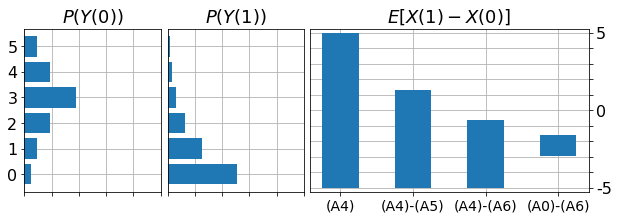

In [45]:
fig = plt.figure(figsize=(8,3))

# spec = gridspec.GridSpec(ncols=3, nrows=1,
#                          width_ratios=[0.5,0.5,1],)

spec = fig.add_gridspec(nrows=1,ncols=2,left=0.01,right=0.495,wspace=0.05)
ax0 = fig.add_subplot(spec[0])
plt.barh(range(K),pyb)
ylim = plt.gca().get_ylim()
#     plt.ylim([0,5])
#     plt.xticks(range(K),fontsize=15)
# plt.xticks(np.arange(0,1.1,0.2),fontsize=15)
plt.xticks(np.arange(0,1.1,0.2),6*[""],fontsize=14)
plt.yticks(fontsize=16)
# plt.ylabel("mRS",fontsize=20)
plt.grid()
plt.title(r"$P(Y(0))$",fontsize=18)
ax0.set_axisbelow(True)

ax1 = fig.add_subplot(spec[1])
plt.barh(range(K),pya)
ylim = plt.gca().get_ylim()
#     plt.ylim([0,5])
#     plt.xticks(range(K),fontsize=15)
plt.xticks(np.arange(0,1.1,0.2),6*[""],fontsize=15)
plt.yticks(range(K),["" for i in range(K)],fontsize=14)
# plt.xlabel("mRS",fontsize=20)
plt.grid()
plt.title(r"$P(Y(1))$",fontsize=18)
ax1.set_axisbelow(True)
ax1.tick_params(axis='y',length=0.0)

spec = fig.add_gridspec(nrows=1,ncols=1,left=0.505,right=0.99,wspace=0.0)
ax2 = fig.add_subplot(spec[0])
plt.bar(range(4),bounds[:,1]-bounds[:,0],bottom=bounds[:,0],width=0.5)
plt.ylim([-5.25,5.25])
# plt.ylim(ylim)
plt.grid()
ax2.set_axisbelow(True)
plt.xticks([0,1,2,3],["(A4)","(A4)-(A5)","(A4)-(A6)","(A0)-(A6)"],fontsize=14)
plt.yticks(range(-5,6),["-5"] + 4*[""] + ["0"] + 4*[""] + ["5"],fontsize=16)
ax2.yaxis.tick_right()
# plt.yticks(fontsize=14)
# #     plt.yticks(np.arange(0,1.1,0.2),["" for y in np.arange(0,1.1,0.2)])
# plt.yticks(np.arange(6),["" for y in np.arange(6)])
# plt.xlabel("Assumptions",fontsize=20)
# #     plt.title(r"$P(X\in\{3,4\})$",fontsize=20)
plt.title(r"$E[X(1) - X(0)]$",fontsize=18)

# plt.tight_layout(pad=0.25)
plt.savefig(f"../output/figures/mrs_rct.pdf",bbox_inches='tight')
plt.show()